# Essentially, testing out my pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from cv2 import SIFT_create, imread, cvtColor, COLOR_BGR2GRAY, GaussianBlur
from skimage.io import imread

from scripts.utils import extract_frames_info
from scripts.display_utils import show_image_with_bbs
from scripts.hog.classifier import HOGClassifier


/gpfs/users/prevotb/.conda/envs/opencv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
frames_info = extract_frames_info("data/train.csv")

In [16]:
classifier = HOGClassifier()

features, labels = classifier.features_labels(frames_info[:10], 1)

100%|██████████| 10/10 [00:00<00:00, 10010.27it/s]


In [19]:
features[1].shape

(34560,)

In [24]:
with open("models/hog/very_neg_64_8.pkl", "rb") as pickle_file:
    classifier = pickle.load(pickle_file)

[1]


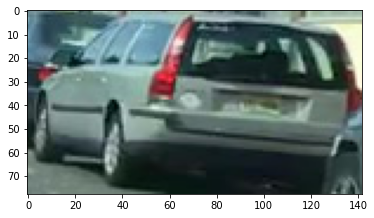

In [25]:
image_index = 100
image = imread(frames_info[image_index][0])

car_index = 5

car_bb = frames_info[image_index][1][car_index]
car_image = image[car_bb[1]: car_bb[1]+car_bb[3], car_bb[0]: car_bb[0]+car_bb[2]]
plt.imshow(car_image)
print(classifier.predict(car_image))

[1]


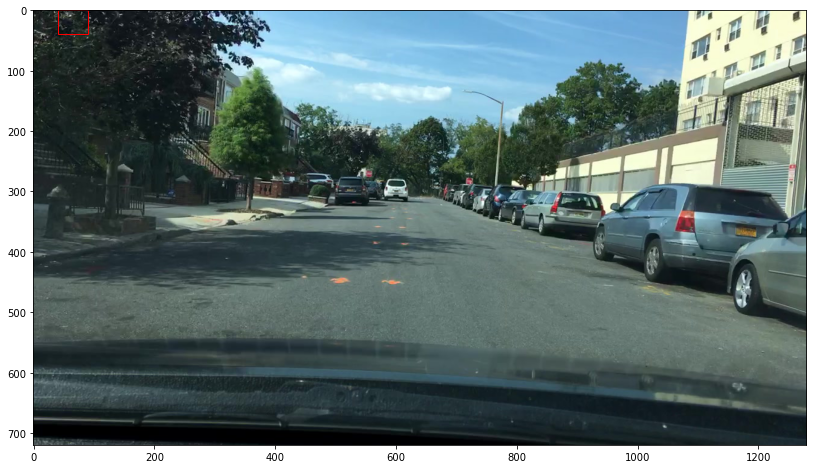

In [66]:
image_index = 100
image = imread(frames_info[image_index][0])

car_bb = [500, 250, 150, 100]
car_image = image[car_bb[1]: car_bb[1]+car_bb[3], car_bb[0]: car_bb[0]+car_bb[2]]
print(classifier.predict(car_image))
show_image_with_bbs(frames_info[image_index][0], [car_bb])

## Testing detection

In [5]:
from scripts.hog.detector import Detector
import pickle
from skimage.io import imread
from scripts.display_utils import show_image_with_bbs

In [6]:
detector = Detector(classifier)

In [29]:
image_index = 2000
image = imread(frames_info[image_index][0])

detections = detector.detect(image, 10, [100, 300, 500], [1.0, .8, .5])
print(len(detections))


100%|██████████| 9/9 [04:40<00:00, 31.18s/it]

44


In [30]:
less_detections = detector.nms(detections, .5)
print(len(less_detections))

11


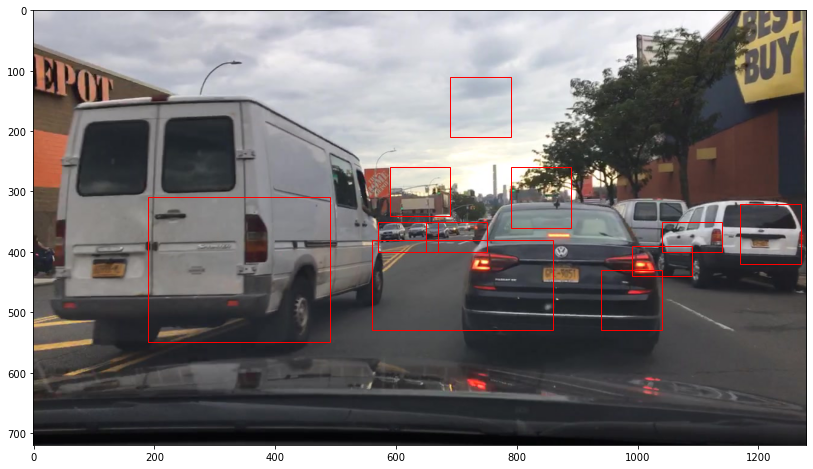

In [31]:

show_image_with_bbs(frames_info[image_index][0], less_detections)


## Hard example mining

In [1]:
from scripts.hog.bounding_box_utils import find_free_window
from random import choice
from tqdm.auto import tqdm

/gpfs/users/prevotb/.conda/envs/opencv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
WINDOW_WIDTHS, WINDOW_RATIOS = [64, 128, 256, 400], [.8, 0.5, 1.0]

WINDOW_SHAPES = [(width, int(width*ratio)) for width in WINDOW_WIDTHS for ratio in WINDOW_RATIOS]
def mine_hard_example(image_path, bboxes, n_examples, classifier):
    pbar = tqdm()
    examples = []
    image = imread(image_path)
    while len(examples) < n_examples:
        window = find_free_window((image.shape[1], image.shape[0]), bboxes, choice(WINDOW_SHAPES))
        if window is None:
            continue
        sub_image = image[window[1]: window[1]+window[3], window[0]: window[0]+window[2]]
        label, feature_vect = classifier.predict(sub_image, True)
        if label:
            examples.append(feature_vect)
            plt.imshow(sub_image)
            plt.show()
            pbar.update()
    pbar.close()
    return examples

0it [00:00, ?it/s]

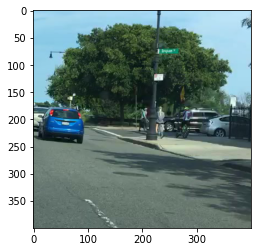

1it [00:08,  8.35s/it]

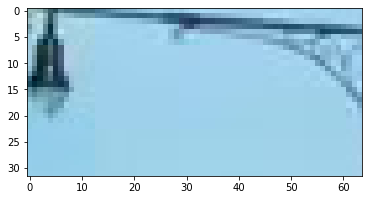

2it [01:14, 42.10s/it]

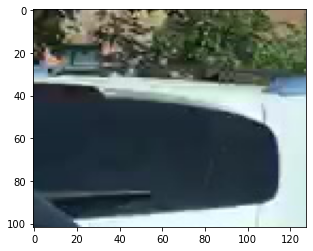

3it [01:26, 28.82s/it]

3


In [7]:
car_index = 0
image_path, bboxes = frames_info[car_index]

hard_examples = mine_hard_example(image_path, bboxes, 3, classifier)
print(len(hard_examples))

## Visualizing final results

In [1]:
from ipywidgets import interact, widgets
from scripts.display_utils import show_image_with_bbs
import pickle


In [4]:
with open("results/hog/last_chance_results.pkl", "rb") as pickle_file:
    test_results = pickle.load(pickle_file)

In [5]:
def f_display(index):
    show_image_with_bbs(os.path.join("data/test", test_results[index][0]), test_results[index][1])

interact(f_display, index=widgets.IntSlider(min=0, max=len(test_results), step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=202), Output()), _dom_classes=('widget-inter…

<function __main__.f_display(index)>